## Music Genre Classification using Audio Features

This notebook demonstrates how to build a music genre classifier using audio features extracted from music files. The project uses PyTorch for neural network implementation and various audio processing techniques to analyze and classify music genres.

### Setup and Imports

First, We import all the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

import evaluate
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Data Loading and Preparation

We'll load the GTZAN dataset from Hugging Face and create our own train/test split:

In [3]:
def load_music_dataset():
    """
    Load the GTZAN dataset and create train/test splits.
    """
    print("Loading dataset...")
    dataset = load_dataset("marsyas/gtzan", "audio")
    
    # Create our own train/test split since the dataset only has 'train'
    full_dataset = dataset['train']
    train_test_split = full_dataset.train_test_split(test_size=0.1, seed=42)
    
    # Create manageable subsets for processing
    train_subset = train_test_split['train'].select(range(min(800, len(train_test_split['train']))))
    test_subset = train_test_split['test'].select(range(min(100, len(train_test_split['test']))))
    
    return train_subset, test_subset

### Feature Extraction

Audio feature extraction is a crucial step in music classification. We'll extract various features including MFCCs, spectral features, and rhythm features:

In [4]:
def extract_features(audio_array, sample_rate):
    """
    Extract audio features from raw audio data using librosa.
    
    Parameters:
    - audio_array: Raw audio signal
    - sample_rate: Sampling rate of the audio
    
    Returns:
    - Dictionary of extracted features
    """
    # Import librosa here to avoid conflicts
    import librosa
    
    # Extract various audio features
    # Mel-frequency cepstral coefficients
    mfccs = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=13)
    
    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_array, sr=sample_rate)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_array, sr=sample_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_array, sr=sample_rate)[0]
    
    # Rhythm features
    tempo, _ = librosa.beat.beat_track(y=audio_array, sr=sample_rate)
    
    # Zero crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_array)[0]
    
    # Compute statistics for each feature
    features = {}
    
    # MFCC stats
    for i in range(mfccs.shape[0]):
        features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i+1}_std'] = np.std(mfccs[i])
        features[f'mfcc{i+1}_skew'] = stats.skew(mfccs[i])
        features[f'mfcc{i+1}_kurtosis'] = stats.kurtosis(mfccs[i])
    
    # Other features stats
    for name, feature in [
        ('spectral_centroid', spectral_centroid),
        ('spectral_bandwidth', spectral_bandwidth), 
        ('spectral_rolloff', spectral_rolloff),
        ('zero_crossing_rate', zero_crossing_rate)
    ]:
        features[f'{name}_mean'] = np.mean(feature)
        features[f'{name}_std'] = np.std(feature)
        features[f'{name}_skew'] = stats.skew(feature)
        features[f'{name}_kurtosis'] = stats.kurtosis(feature)
    
    # Add tempo
    features['tempo'] = tempo
    
    return features

def process_dataset(dataset_split):
    """
    Process audio files from the dataset and extract features.
    
    Parameters:
    - dataset_split: Dataset split to process
    
    Returns:
    - DataFrame of features and list of labels
    """
    features_list = []
    labels = []
    
    for item in dataset_split:
        audio = item['audio']
        audio_array = audio['array']
        sample_rate = audio['sampling_rate']
        genre = item['genre']
        
        # Extract features
        features = extract_features(audio_array, sample_rate)
        features_list.append(features)
        labels.append(genre)
    
    # Convert to DataFrame
    df = pd.DataFrame(features_list)
    
    return df, labels

### Data Preparation

Now let's prepare our data for modeling:

In [5]:
def prepare_data(X_train, y_train, X_test, y_test):
    """
    Prepare data for training - create label mappings, scale features, 
    and create PyTorch datasets and dataloaders.
    
    Returns:
    - Prepared datasets, dataloaders, and metadata
    """
    # Create label mapping
    label_mapping = {label: idx for idx, label in enumerate(sorted(set(y_train)))}
    inv_label_mapping = {idx: label for label, idx in label_mapping.items()}
    
    # Convert labels to indices
    y_train_indices = [label_mapping[label] for label in y_train]
    y_test_indices = [label_mapping[label] for label in y_test]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Split training data into training and validation
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_scaled, y_train_indices, test_size=0.2, random_state=42
    )
    
    # Create datasets
    train_final_dataset = MusicDataset(X_train_final, y_train_final)
    val_dataset = MusicDataset(X_val, y_val)
    test_dataset = MusicDataset(X_test_scaled, y_test_indices)
    
    # Create dataloaders
    train_final_loader = DataLoader(train_final_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return {
        'train_loader': train_final_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'scaler': scaler,
        'label_mapping': label_mapping,
        'inv_label_mapping': inv_label_mapping,
        'input_size': X_train.shape[1],
        'num_classes': len(label_mapping),
        'X_train_scaled': X_train_scaled,
        'y_train_indices': y_train_indices,
        'X_test_scaled': X_test_scaled,
        'y_test_indices': y_test_indices
    }

### PyTorch Dataset

Create a custom PyTorch dataset for our music data:

In [6]:
class MusicDataset(Dataset):
    """
    PyTorch Dataset for music genre classification.
    """
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

### Model Architecture

Define our neural network architecture for genre classification:

In [7]:
class MusicGenreClassifier(nn.Module):
    """
    Neural network model for music genre classification.
    """
    def __init__(self, input_size, num_classes):
        super(MusicGenreClassifier, self).__init__()
        
        # Architecture with dropout for regularization
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

def create_model(input_size, num_classes):
    """
    Create and initialize the model, loss function, and optimizer.
    """
    model = MusicGenreClassifier(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    return model, criterion, optimizer

### Training Function

Creat a function to train our model:

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    """
    Train the neural network model.
    
    Parameters:
    - model: PyTorch model
    - criterion: Loss function
    - optimizer: Optimizer
    - train_loader: Training data loader
    - val_loader: Validation data loader
    - num_epochs: Number of epochs to train
    
    Returns:
    - Lists of training/validation losses and accuracies
    """
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        accuracy = correct / total
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {accuracy:.4f}')
    
    return train_losses, val_losses, val_accuracies

### Evaluation Function

Define a function to evaluate our model:

In [9]:
def evaluate_model(model, test_loader, inv_label_mapping):
    """
    Evaluate the trained model on test data.
    
    Parameters:
    - model: Trained PyTorch model
    - test_loader: Test data loader
    - inv_label_mapping: Inverse label mapping dictionary
    
    Returns:
    - Dictionary of evaluation results
    """
    # Initialize evaluate metric
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics using evaluate
    accuracy = accuracy_metric.compute(predictions=all_preds, references=all_labels)
    f1 = f1_metric.compute(predictions=all_preds, references=all_labels, average='macro')
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print classification report
    print("\nClassification Report:")
    genre_names = [str(inv_label_mapping[i]) for i in range(len(inv_label_mapping))]
    print(classification_report(all_labels, all_preds, target_names=genre_names))
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels
    }

### Visualization Function

Create functions to visualize our results:

In [10]:
def plot_confusion_matrix(cm, inv_label_mapping):
    """
    Plot confusion matrix for model evaluation.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[inv_label_mapping[i] for i in range(len(inv_label_mapping))],
                yticklabels=[inv_label_mapping[i] for i in range(len(inv_label_mapping))])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_training_history(train_losses, val_losses, val_accuracies):
    """
    Plot training history graphs.
    """
    # Plot training/validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### SKLearn Integration

Create a wrapper to use our PyTorch model with scikit-learn

In [11]:
class PyTorchWrapper(BaseEstimator):
    """
    Wrapper class to use PyTorch models with scikit-learn.
    """
    def __init__(self, model, criterion, optimizer, epochs=15, batch_size=32):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
    def fit(self, X, y):
        # Convert data to PyTorch datasets
        dataset = MusicDataset(X, y)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Train the model
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {running_loss/len(dataset):.4f}')
        return self
    
    def predict(self, X):
        # Convert to PyTorch tensor
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        
        # Set model to evaluation mode
        self.model.eval()
        
        # Make predictions
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
        
        return predicted.cpu().numpy()

def create_pipeline(input_size, num_classes):
    """
    Create sklearn Pipeline with PyTorch model.
    """
    model = MusicGenreClassifier(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', PyTorchWrapper(model, criterion, optimizer, epochs=5))
    ])
    
    return pipeline

### Main Function

Create a main function to orchestrate the entire process

In [12]:
def run_music_classification():
    """
    Main function to run the entire music genre classification pipeline.
    """
    # Step 1: Load dataset
    train_subset, test_subset = load_music_dataset()
    
    # Step 2: Extract features
    print("Extracting audio features (this may take a while)...")
    X_train, y_train = process_dataset(train_subset)
    X_test, y_test = process_dataset(test_subset)
    
    # Step 3: Prepare data
    data = prepare_data(X_train, y_train, X_test, y_test)
    
    # Step 4: Create model
    model, criterion, optimizer = create_model(
        data['input_size'], 
        data['num_classes']
    )
    
    # Step 5: Train model
    print("\nTraining the model...")
    train_losses, val_losses, val_accuracies = train_model(
        model, criterion, optimizer, 
        data['train_loader'], data['val_loader'], 
        num_epochs=15
    )
    
    # Step 6: Evaluate model
    print("\nEvaluating the model...")
    eval_results = evaluate_model(
        model, 
        data['test_loader'], 
        data['inv_label_mapping']
    )
    
    # Step 7: Plot results
    plot_confusion_matrix(eval_results['confusion_matrix'], data['inv_label_mapping'])
    plot_training_history(train_losses, val_losses, val_accuracies)
    
    # Step 8: Save model
    torch.save(model.state_dict(), 'music_genre_classifier.pth')
    print("\nModel saved as 'music_genre_classifier.pth'")
    
    # Step 9: Example of using sklearn Pipeline
    print("\nExample of using sklearn Pipeline with PyTorch model:")
    pipeline = create_pipeline(data['input_size'], data['num_classes'])
    
    print("Fitting pipeline...")
    pipeline.fit(X_train, data['y_train_indices'])
    y_pred = pipeline.predict(X_test)
    
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(
        predictions=y_pred, 
        references=data['y_test_indices']
    )
    print(f"Pipeline Test Accuracy: {accuracy['accuracy']:.4f}")
    
    return {
        'model': model,
        'data': data,
        'eval_results': eval_results,
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
    }

### Usage Example

Let's put all of this together and show how to use the modularized code:

Loading dataset...
Extracting audio features (this may take a while)...

Training the model...
Epoch 1/15, Train Loss: 2.1019, Val Loss: 1.8894, Val Accuracy: 0.4000
Epoch 2/15, Train Loss: 1.5657, Val Loss: 1.4960, Val Accuracy: 0.5000
Epoch 3/15, Train Loss: 1.3641, Val Loss: 1.3446, Val Accuracy: 0.5250
Epoch 4/15, Train Loss: 1.2024, Val Loss: 1.2620, Val Accuracy: 0.5563
Epoch 5/15, Train Loss: 1.0534, Val Loss: 1.2043, Val Accuracy: 0.5500
Epoch 6/15, Train Loss: 0.9811, Val Loss: 1.1487, Val Accuracy: 0.6000
Epoch 7/15, Train Loss: 0.8413, Val Loss: 1.0613, Val Accuracy: 0.6625
Epoch 8/15, Train Loss: 0.7702, Val Loss: 1.0487, Val Accuracy: 0.6562
Epoch 9/15, Train Loss: 0.7378, Val Loss: 1.0201, Val Accuracy: 0.6500
Epoch 10/15, Train Loss: 0.6859, Val Loss: 1.0556, Val Accuracy: 0.6062
Epoch 11/15, Train Loss: 0.6055, Val Loss: 1.0350, Val Accuracy: 0.6687
Epoch 12/15, Train Loss: 0.5748, Val Loss: 1.0370, Val Accuracy: 0.6500
Epoch 13/15, Train Loss: 0.5129, Val Loss: 1.0114,


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.86      0.67      0.75         9
           2       0.43      0.75      0.55         8
           3       0.57      0.67      0.62         6
           4       0.91      0.77      0.83        13
           5       0.58      0.78      0.67         9
           6       0.86      0.86      0.86        14
           7       0.82      1.00      0.90         9
           8       0.56      0.71      0.62         7
           9       0.80      0.53      0.64        15

    accuracy                           0.72       100
   macro avg       0.74      0.72      0.71       100
weighted avg       0.77      0.72      0.72       100



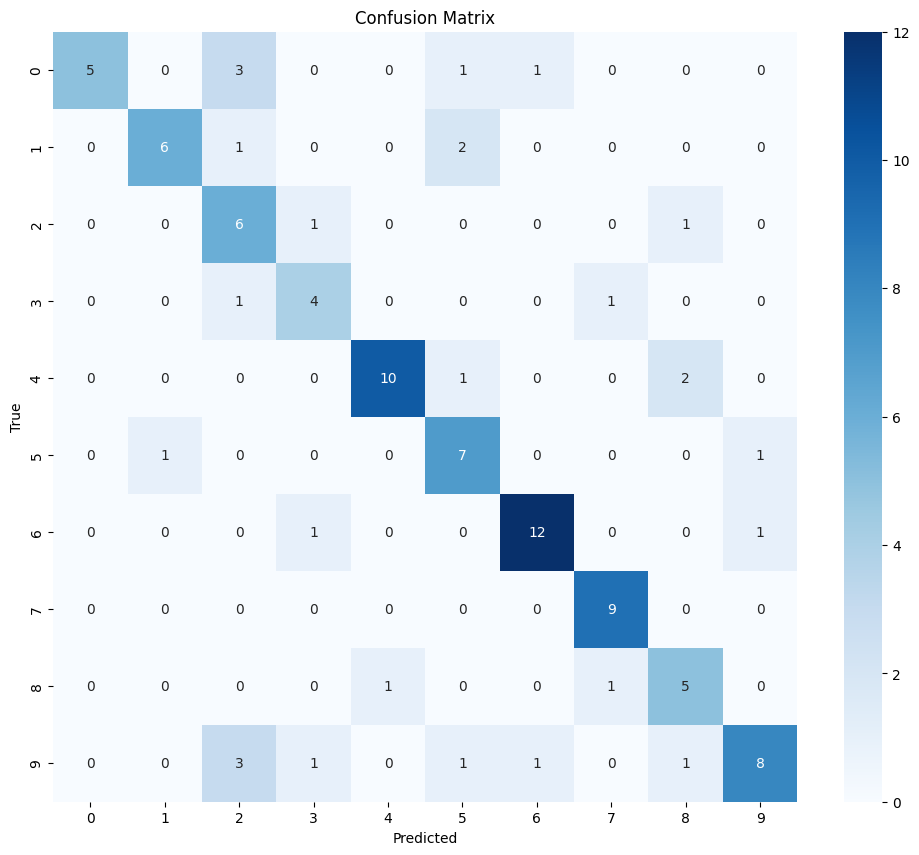

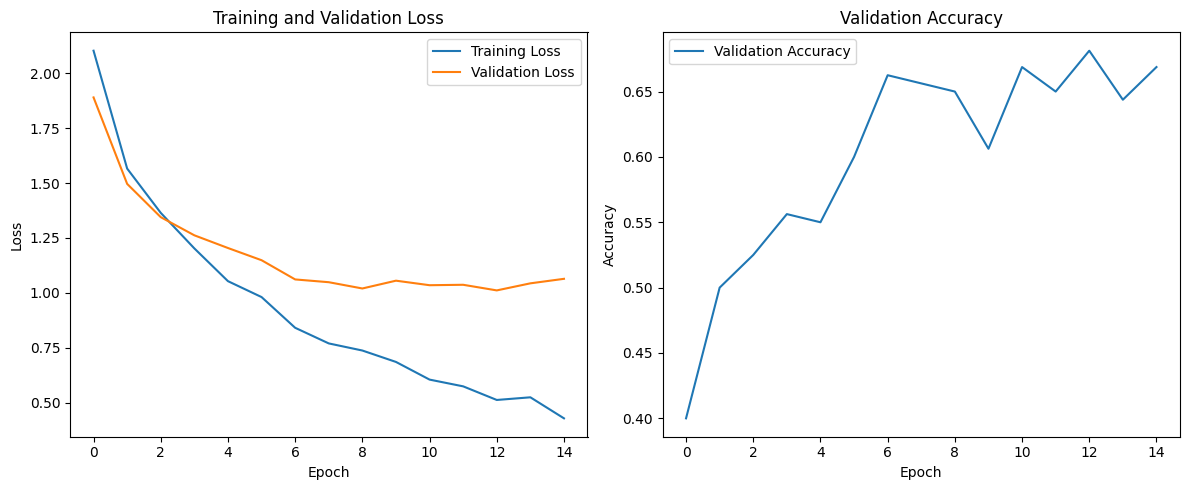


Model saved as 'music_genre_classifier.pth'

Example of using sklearn Pipeline with PyTorch model:
Fitting pipeline...
Epoch 1/5, Loss: 2.0769
Epoch 2/5, Loss: 1.5672
Epoch 3/5, Loss: 1.3529
Epoch 4/5, Loss: 1.1390
Epoch 5/5, Loss: 1.0235
Pipeline Test Accuracy: 0.6500

Final Test Accuracy: 0.7200
F1 Score (Macro): 0.7100


In [13]:
# Run the entire pipeline
results = run_music_classification()

# Access the model and evaluation results
model = results['model']
eval_results = results['eval_results']

print(f"\nFinal Test Accuracy: {eval_results['accuracy']['accuracy']:.4f}")
print(f"F1 Score (Macro): {eval_results['f1']['f1']:.4f}")

## Future Improvements

Here are some ways to further improve this music genre classification system:

- K-fold cross-validation: Implement k-fold cross-validation to get a more robust estimate of model performance.
- Neural network architecture: Experiment with different architectures, such as convolutional neural networks (CNNs) specifically designed for audio data.
- Early stopping: Implement early stopping to prevent overfitting and reduce training time.
- Feature importance analysis: Analyze which audio features are most important for genre classification.
- Data augmentation: Implement audio data augmentation techniques such as time stretching, pitch shifting, and adding noise.
- Transfer learning: Use pretrained audio models as feature extractors.
- Hyperparameter optimization: Use techniques like grid search or Bayesian optimization to find the best hyperparameters.
- Ensemble methods: Combine multiple models for improved performance.
- Raw audio processing: Work directly with raw audio waveforms or spectrograms rather than extracted features.
- Advanced audio features: Experiment with additional audio features such as chroma features or harmonic-percussive source separation.